In [13]:
import torch.multiprocessing as mp

if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)

from torch import optim
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch
import random
import numpy as np
import torch.nn as nn
import albumentations as Albu
import pandas as pd
from torch.utils.data.sampler import RandomSampler
from warmup_scheduler import GradualWarmupScheduler
import os
from utils.dataset import PandasDataset, RGB2Fusion, RGB2FusionTorch
from utils.metrics import model_checkpoint
from utils.train import train_model
from utils.models import EfficientNetApi, EfficientNetApiGem

In [14]:
seed = 42
shuffle = True
batch_size = 8
num_workers = 4
output_classes = 5
init_lr = 3e-4
warmup_factor = 10
warmup_epochs = 1
n_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
loss_function = nn.BCEWithLogitsLoss()

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

ROOT_DIR = '../..'

data_dir = '../../../dataset'
images_dir = os.path.join(data_dir, 'tiles')

Using device: cuda


In [15]:
load_model = efficientnet_b0(
     weights=EfficientNet_B0_Weights.DEFAULT
)
model = EfficientNetApiGem(model=load_model, output_dimensions=output_classes)
model = model.to(device)

In [16]:
print("Using device:", device)
loss_function = nn.BCEWithLogitsLoss()

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Using device: cuda


In [17]:
df_train_ = pd.read_csv(f"{ROOT_DIR}/data/train_5fold.csv")
df_train_.columns = df_train_.columns.str.strip()
train_indexes = np.where((df_train_['fold'] != 3))[0]
valid_indexes = np.where((df_train_['fold'] == 3))[0]
#
df_train = df_train_.loc[train_indexes]
df_val = df_train_.loc[valid_indexes]
df_test = pd.read_csv(f"{ROOT_DIR}/data/test.csv")

#### view data

In [18]:
(df_train.shape, df_val.shape, df_test.shape)

((7219, 5), (1805, 5), (1592, 4))

In [19]:
transforms = Albu.Compose([
    RGB2FusionTorch(mode="mean", space_colors=["rgb", "xyz", "lab"]),
    Albu.Transpose(p=0.5),
    Albu.VerticalFlip(p=0.5),
    Albu.HorizontalFlip(p=0.5),
])

valid_transforms = Albu.Compose([
    RGB2FusionTorch(mode="mean", space_colors=["rgb", "xyz", "lab"])
])

In [27]:
df_train.columns = df_train.columns.str.strip()

train_dataset = PandasDataset(images_dir, df_train, transforms=transforms)
valid_dataset = PandasDataset(images_dir, df_val, transforms=valid_transforms)
test_dataset = PandasDataset(images_dir, df_test, transforms=valid_transforms)

tensor(0.0158)
tensor(1.)


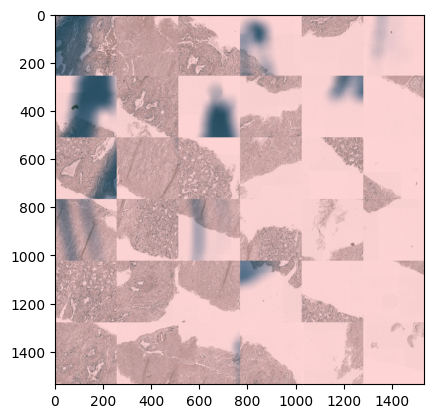

In [28]:
import matplotlib.pyplot as plt
print(train_dataset[0][0].min())
print(train_dataset[0][0].max())

img = train_dataset[0][0].permute(1, 2, 0).numpy()


plt.imshow(img)

In [29]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=RandomSampler(train_dataset)
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, num_workers=num_workers, sampler = RandomSampler(valid_dataset)
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, sampler = RandomSampler(test_dataset)
)

In [30]:
optimizer = optim.Adam(model.parameters(), lr = init_lr / warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs - warmup_epochs)
scheduler = GradualWarmupScheduler(optimizer, multiplier = warmup_factor, total_epoch = warmup_epochs, after_scheduler=scheduler_cosine)

In [24]:
train_model(
    model=model,
    epochs=n_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    checkpoint=model_checkpoint,
    device=device,
    loss_function=loss_function,
    path_to_save_metrics="logs/fusion-mean.txt",
    path_to_save_model="models/fusion-mean.pth",
    patience=5,
)

Epoch 1/50



100%|██████████| 226/226 [01:57<00:00,  1.92it/s]


metrics {'val_loss': np.float32(0.34441093), 'val_acc': {'mean': np.float64(40.34747923314571), 'std': np.float64(1.164357820568627), 'ci_5': np.float64(38.44875395298004), 'ci_95': np.float64(42.32687056064606)}, 'val_kappa': {'mean': np.float64(0.7079993444859415), 'std': np.float64(0.012733288011448796), 'ci_5': np.float64(0.6870820385293513), 'ci_95': np.float64(0.7279527141935083)}, 'val_f1': {'mean': np.float64(0.34138141611218453), 'std': np.float64(0.011219640762618457), 'ci_5': np.float64(0.32259309887886045), 'ci_95': np.float64(0.36042730063199996)}, 'val_recall': {'mean': np.float64(0.35245207488536834), 'std': np.float64(0.010941104607513085), 'ci_5': np.float64(0.33345443457365037), 'ci_95': np.float64(0.37087277323007584)}, 'val_precision': {'mean': np.float64(0.4315346020758152), 'std': np.float64(0.019824436318006816), 'ci_5': np.float64(0.39794488400220873), 'ci_95': np.float64(0.46175382733345033)}}
Salvando o melhor modelo... 0.0 -> 0.7079993444859415
Epoch 2/50



100%|██████████| 226/226 [01:55<00:00,  1.95it/s]
/home/woshington/Projects/Doutorado/repo/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


metrics {'val_loss': np.float32(0.29069602), 'val_acc': {'mean': np.float64(50.075069105625154), 'std': np.float64(1.1943524889615587), 'ci_5': np.float64(48.088642954826355), 'ci_95': np.float64(52.13296413421631)}, 'val_kappa': {'mean': np.float64(0.7663668656015526), 'std': np.float64(0.011701033774132383), 'ci_5': np.float64(0.7472102068913467), 'ci_95': np.float64(0.7851444480766735)}, 'val_f1': {'mean': np.float64(0.4304856286644936), 'std': np.float64(0.012469790365131135), 'ci_5': np.float64(0.40993913561105727), 'ci_95': np.float64(0.45150935351848603)}, 'val_recall': {'mean': np.float64(0.4317604559063911), 'std': np.float64(0.011108594764301741), 'ci_5': np.float64(0.41438632607460024), 'ci_95': np.float64(0.4507644593715668)}, 'val_precision': {'mean': np.float64(0.5387156799733639), 'std': np.float64(0.012787447833533694), 'ci_5': np.float64(0.5170457988977433), 'ci_95': np.float64(0.5591854304075241)}}
Salvando o melhor modelo... 0.7079993444859415 -> 0.7663668656015526
E

100%|██████████| 226/226 [01:55<00:00,  1.95it/s]


metrics {'val_loss': np.float32(0.3171897), 'val_acc': {'mean': np.float64(52.53357360363007), 'std': np.float64(1.1929377504698153), 'ci_5': np.float64(50.52631497383118), 'ci_95': np.float64(54.51800674200058)}, 'val_kappa': {'mean': np.float64(0.7387628132732784), 'std': np.float64(0.013331345104522654), 'ci_5': np.float64(0.7165360811590462), 'ci_95': np.float64(0.7606084406939823)}, 'val_f1': {'mean': np.float64(0.4408271019756794), 'std': np.float64(0.012226690225294863), 'ci_5': np.float64(0.42117378264665606), 'ci_95': np.float64(0.4610803738236427)}, 'val_recall': {'mean': np.float64(0.44185744029283525), 'std': np.float64(0.010867221090624732), 'ci_5': np.float64(0.4240454971790314), 'ci_95': np.float64(0.4599313855171204)}, 'val_precision': {'mean': np.float64(0.5333140625655651), 'std': np.float64(0.014840497391658328), 'ci_5': np.float64(0.5089858710765839), 'ci_95': np.float64(0.5572472333908081)}}
Epoch 4/50



100%|██████████| 226/226 [01:56<00:00,  1.94it/s]


metrics {'val_loss': np.float32(0.3007906), 'val_acc': {'mean': np.float64(58.2659831404686), 'std': np.float64(1.1500664672278942), 'ci_5': np.float64(56.398892402648926), 'ci_95': np.float64(60.221606492996216)}, 'val_kappa': {'mean': np.float64(0.8023013785776089), 'std': np.float64(0.012243763531721293), 'ci_5': np.float64(0.7823299874067338), 'ci_95': np.float64(0.822196345561367)}, 'val_f1': {'mean': np.float64(0.5132413515448571), 'std': np.float64(0.012134079594966044), 'ci_5': np.float64(0.49362794905900953), 'ci_95': np.float64(0.5327567517757416)}, 'val_recall': {'mean': np.float64(0.5120402656793595), 'std': np.float64(0.011662791988511625), 'ci_5': np.float64(0.49324339628219604), 'ci_95': np.float64(0.5312781810760498)}, 'val_precision': {'mean': np.float64(0.5397410867214203), 'std': np.float64(0.012741117076937742), 'ci_5': np.float64(0.5191676110029221), 'ci_95': np.float64(0.5613364279270172)}}
Salvando o melhor modelo... 0.7663668656015526 -> 0.8023013785776089
Epoch

100%|██████████| 226/226 [01:55<00:00,  1.95it/s]


metrics {'val_loss': np.float32(0.38671795), 'val_acc': {'mean': np.float64(59.153683960437775), 'std': np.float64(1.140348422540672), 'ci_5': np.float64(57.337947487831116), 'ci_95': np.float64(60.99722981452942)}, 'val_kappa': {'mean': np.float64(0.7945727591314037), 'std': np.float64(0.012741031500202556), 'ci_5': np.float64(0.773527144807581), 'ci_95': np.float64(0.8148689080463828)}, 'val_f1': {'mean': np.float64(0.520659074395895), 'std': np.float64(0.011955702543433361), 'ci_5': np.float64(0.5017581880092621), 'ci_95': np.float64(0.5403113901615143)}, 'val_recall': {'mean': np.float64(0.5209073608219623), 'std': np.float64(0.011403119159764675), 'ci_5': np.float64(0.5022290766239166), 'ci_95': np.float64(0.5394072085618973)}, 'val_precision': {'mean': np.float64(0.5388326371312141), 'std': np.float64(0.012574170849558208), 'ci_5': np.float64(0.5179185301065445), 'ci_95': np.float64(0.5590949147939682)}}
Epoch 6/50



100%|██████████| 226/226 [01:55<00:00,  1.95it/s]


metrics {'val_loss': np.float32(0.35539427), 'val_acc': {'mean': np.float64(58.47008289694786), 'std': np.float64(1.1753260958681877), 'ci_5': np.float64(56.565093994140625), 'ci_95': np.float64(60.44321060180664)}, 'val_kappa': {'mean': np.float64(0.8012462454141867), 'std': np.float64(0.012230248228973043), 'ci_5': np.float64(0.78142332681175), 'ci_95': np.float64(0.8209931624942354)}, 'val_f1': {'mean': np.float64(0.5300353096723557), 'std': np.float64(0.012234045369618649), 'ci_5': np.float64(0.5095970869064331), 'ci_95': np.float64(0.5503471225500107)}, 'val_recall': {'mean': np.float64(0.5252608770728111), 'std': np.float64(0.012134529879659713), 'ci_5': np.float64(0.5046550214290619), 'ci_95': np.float64(0.5454680532217026)}, 'val_precision': {'mean': np.float64(0.5439518817067146), 'std': np.float64(0.012502098841524707), 'ci_5': np.float64(0.5238990426063538), 'ci_95': np.float64(0.5648847281932831)}}
Epoch 7/50



100%|██████████| 226/226 [01:55<00:00,  1.95it/s]


metrics {'val_loss': np.float32(0.43162152), 'val_acc': {'mean': np.float64(60.17867022752762), 'std': np.float64(1.175492671876724), 'ci_5': np.float64(58.22714567184448), 'ci_95': np.float64(62.04985976219177)}, 'val_kappa': {'mean': np.float64(0.8032942444118685), 'std': np.float64(0.012483357244419934), 'ci_5': np.float64(0.7829071304105801), 'ci_95': np.float64(0.8235485623492743)}, 'val_f1': {'mean': np.float64(0.5350919849574566), 'std': np.float64(0.012849664024021178), 'ci_5': np.float64(0.5138441562652588), 'ci_95': np.float64(0.5555796116590499)}, 'val_recall': {'mean': np.float64(0.5330636197328568), 'std': np.float64(0.012349325138613684), 'ci_5': np.float64(0.5131576478481292), 'ci_95': np.float64(0.552718797326088)}, 'val_precision': {'mean': np.float64(0.5587698223590851), 'std': np.float64(0.013287699032489407), 'ci_5': np.float64(0.5380007773637772), 'ci_95': np.float64(0.5808888822793961)}}
Salvando o melhor modelo... 0.8023013785776089 -> 0.8032942444118685
Epoch 8/

100%|██████████| 226/226 [01:55<00:00,  1.96it/s]


metrics {'val_loss': np.float32(0.5444095), 'val_acc': {'mean': np.float64(60.45434889793396), 'std': np.float64(1.1578107867047025), 'ci_5': np.float64(58.61218720674515), 'ci_95': np.float64(62.4930739402771)}, 'val_kappa': {'mean': np.float64(0.7972032019374585), 'std': np.float64(0.012605138845091662), 'ci_5': np.float64(0.7775387350449986), 'ci_95': np.float64(0.8181058146819388)}, 'val_f1': {'mean': np.float64(0.5337084021270275), 'std': np.float64(0.012444009128599609), 'ci_5': np.float64(0.5142594903707505), 'ci_95': np.float64(0.5542675644159317)}, 'val_recall': {'mean': np.float64(0.5324577191472053), 'std': np.float64(0.011870819958744342), 'ci_5': np.float64(0.5136104971170425), 'ci_95': np.float64(0.5520642340183258)}, 'val_precision': {'mean': np.float64(0.55795639783144), 'std': np.float64(0.013209606998959591), 'ci_5': np.float64(0.5360073059797287), 'ci_95': np.float64(0.579478207230568)}}
Epoch 9/50



100%|██████████| 226/226 [01:55<00:00,  1.96it/s]


metrics {'val_loss': np.float32(0.4745923), 'val_acc': {'mean': np.float64(61.37135728001594), 'std': np.float64(1.1524318739413906), 'ci_5': np.float64(59.44598317146301), 'ci_95': np.float64(63.2686972618103)}, 'val_kappa': {'mean': np.float64(0.8172682148635441), 'std': np.float64(0.01197666233649923), 'ci_5': np.float64(0.7979369992118694), 'ci_95': np.float64(0.8376359468774334)}, 'val_f1': {'mean': np.float64(0.5421107208132744), 'std': np.float64(0.012225321882830103), 'ci_5': np.float64(0.5217190504074096), 'ci_95': np.float64(0.5626807689666748)}, 'val_recall': {'mean': np.float64(0.5438240456581116), 'std': np.float64(0.011715641564152257), 'ci_5': np.float64(0.5232005208730698), 'ci_95': np.float64(0.562258267402649)}, 'val_precision': {'mean': np.float64(0.5529903758168221), 'std': np.float64(0.0132060431108465), 'ci_5': np.float64(0.5310299634933472), 'ci_95': np.float64(0.5751159995794296)}}
Salvando o melhor modelo... 0.8032942444118685 -> 0.8172682148635441
Epoch 10/50


100%|██████████| 226/226 [02:02<00:00,  1.84it/s]


metrics {'val_loss': np.float32(0.56206393), 'val_acc': {'mean': np.float64(62.42415511608124), 'std': np.float64(1.155323968483174), 'ci_5': np.float64(60.498613119125366), 'ci_95': np.float64(64.26870048046112)}, 'val_kappa': {'mean': np.float64(0.7993327040794904), 'std': np.float64(0.012835065694756691), 'ci_5': np.float64(0.7773690921036015), 'ci_95': np.float64(0.8202480968729903)}, 'val_f1': {'mean': np.float64(0.5576591085791588), 'std': np.float64(0.012443258467611231), 'ci_5': np.float64(0.536800280213356), 'ci_95': np.float64(0.5773867815732956)}, 'val_recall': {'mean': np.float64(0.5549314013123512), 'std': np.float64(0.011906895097692086), 'ci_5': np.float64(0.5347080707550049), 'ci_95': np.float64(0.5730368524789811)}, 'val_precision': {'mean': np.float64(0.5708036018610001), 'std': np.float64(0.013317063565127562), 'ci_5': np.float64(0.5488149523735046), 'ci_95': np.float64(0.5918310075998306)}}
Epoch 11/50



100%|██████████| 226/226 [01:59<00:00,  1.88it/s]


metrics {'val_loss': np.float32(0.5033816), 'val_acc': {'mean': np.float64(61.45828250050545), 'std': np.float64(1.1331426479593505), 'ci_5': np.float64(59.61219072341919), 'ci_95': np.float64(63.32409977912903)}, 'val_kappa': {'mean': np.float64(0.8139700360375721), 'std': np.float64(0.012081889261108394), 'ci_5': np.float64(0.7937258410424691), 'ci_95': np.float64(0.833710060944536)}, 'val_f1': {'mean': np.float64(0.5558247314095497), 'std': np.float64(0.01222406274178583), 'ci_5': np.float64(0.535618731379509), 'ci_95': np.float64(0.5764102309942245)}, 'val_recall': {'mean': np.float64(0.5531696706414223), 'std': np.float64(0.011966688678097066), 'ci_5': np.float64(0.5332734167575837), 'ci_95': np.float64(0.5733352571725845)}, 'val_precision': {'mean': np.float64(0.5687082787156105), 'std': np.float64(0.012610933910968012), 'ci_5': np.float64(0.5475961565971375), 'ci_95': np.float64(0.589873531460762)}}
Epoch 12/50



100%|██████████| 226/226 [01:59<00:00,  1.88it/s]


metrics {'val_loss': np.float32(0.55530316), 'val_acc': {'mean': np.float64(60.43534609079361), 'std': np.float64(1.1771594102729928), 'ci_5': np.float64(58.55678468942642), 'ci_95': np.float64(62.385039031505585)}, 'val_kappa': {'mean': np.float64(0.7992450092049758), 'std': np.float64(0.01298667846391695), 'ci_5': np.float64(0.7773303944157723), 'ci_95': np.float64(0.819825906709812)}, 'val_f1': {'mean': np.float64(0.5386061717867852), 'std': np.float64(0.012386923874115491), 'ci_5': np.float64(0.517836132645607), 'ci_95': np.float64(0.559509664773941)}, 'val_recall': {'mean': np.float64(0.5476991800069809), 'std': np.float64(0.011920400032394213), 'ci_5': np.float64(0.5280217796564102), 'ci_95': np.float64(0.5672383606433868)}, 'val_precision': {'mean': np.float64(0.5401676457524299), 'std': np.float64(0.012895464461419303), 'ci_5': np.float64(0.5189775913953781), 'ci_95': np.float64(0.5616624414920807)}}
Epoch 13/50



100%|██████████| 226/226 [02:02<00:00,  1.84it/s]


metrics {'val_loss': np.float32(0.5504703), 'val_acc': {'mean': np.float64(62.86310255527496), 'std': np.float64(1.1222414042553064), 'ci_5': np.float64(60.99722981452942), 'ci_95': np.float64(64.81994390487671)}, 'val_kappa': {'mean': np.float64(0.8066201647629113), 'std': np.float64(0.012960523644956676), 'ci_5': np.float64(0.785495441911635), 'ci_95': np.float64(0.8278078514065951)}, 'val_f1': {'mean': np.float64(0.5707244480252266), 'std': np.float64(0.012114437812523417), 'ci_5': np.float64(0.5500908046960831), 'ci_95': np.float64(0.589584332704544)}, 'val_recall': {'mean': np.float64(0.5688075008392334), 'std': np.float64(0.011877313785943158), 'ci_5': np.float64(0.5487468123435975), 'ci_95': np.float64(0.5882753372192383)}, 'val_precision': {'mean': np.float64(0.5805798966288567), 'std': np.float64(0.012537900516123012), 'ci_5': np.float64(0.5600986301898956), 'ci_95': np.float64(0.6007286876440048)}}
Epoch 14/50



100%|██████████| 226/226 [02:16<00:00,  1.65it/s]


metrics {'val_loss': np.float32(0.66545254), 'val_acc': {'mean': np.float64(59.88443195819855), 'std': np.float64(1.1390569637491261), 'ci_5': np.float64(58.11634063720703), 'ci_95': np.float64(61.88365817070007)}, 'val_kappa': {'mean': np.float64(0.7979034259434213), 'std': np.float64(0.012930426009531126), 'ci_5': np.float64(0.7774852875006938), 'ci_95': np.float64(0.8190844621031923)}, 'val_f1': {'mean': np.float64(0.522441065967083), 'std': np.float64(0.012041883140626078), 'ci_5': np.float64(0.5024758249521255), 'ci_95': np.float64(0.5420458883047103)}, 'val_recall': {'mean': np.float64(0.5315514253377914), 'std': np.float64(0.011470948714244348), 'ci_5': np.float64(0.5123189240694046), 'ci_95': np.float64(0.5503134846687316)}, 'val_precision': {'mean': np.float64(0.5293277918100358), 'std': np.float64(0.012872945559898997), 'ci_5': np.float64(0.5084042012691498), 'ci_95': np.float64(0.5506467640399932)}}

Early stopping at epoch 14. No improvement for 5 epochs.
Best epoch: 9 with

# tests

In [31]:
from utils.metrics import evaluation, format_metrics
model.load_state_dict(
    torch.load(f"models/fusion-mean.pth")
)
response = evaluation(model, test_loader, device)
result = format_metrics(response[0])
print(result)

100%|██████████| 199/199 [01:35<00:00,  2.08it/s]


VAL_ACC      Mean: 62.17 | Std: 1.24 | 95% CI: [60.24, 64.26]
VAL_KAPPA    Mean: 0.83 | Std: 0.01 | 95% CI: [0.81, 0.85]
VAL_F1       Mean: 0.55 | Std: 0.01 | 95% CI: [0.53, 0.57]
VAL_RECALL   Mean: 0.55 | Std: 0.01 | 95% CI: [0.53, 0.57]
VAL_PRECISION Mean: 0.56 | Std: 0.01 | 95% CI: [0.54, 0.58]
